In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN


pd.options.display.float_format = '{:,.2f}'.format


%matplotlib inline

# Prepare data

In [2]:
from ngc_claims_functions import  *


# Read Generali data
train, test, target = read_generali_data()

# Merge under represented categories in the generali data
train = merge_generali_data(train)
test = merge_generali_data(test) 

#Define categ_col_list
categ_col_list = [col for col in train.columns if 'categ' in col]
categ_col_list.remove("ft_22_categ")

# Tranform to dummies
train_dummies, test_dummies = dummies(train, test , columns = categ_col_list)

# Filter out rows with Insee data
# All the following analyze will have to create a model with only data provided by Generali
test_dummies = test_dummies[with_Insee_mask(test)==False]
test_dummies.reset_index(inplace=True)



## Impute NaN

In [3]:
insee = train_dummies["Insee"].copy()
del  train_dummies["Insee"]
del  test_dummies["Insee"]

# Impute with KNN
train_dummies,knn_22, knn_superficie = impute_categ_knn(train_dummies, 5)
test_dummies = impute_categ_knn(test_dummies, 0, knn_superficie, knn_22=None)


# Create some features to help model
train_dummies = create_features(train_dummies, train)
test_dummies = create_features(test_dummies, test)

## Identify Outliers

In [6]:
from sklearn.cluster import DBSCAN

n_epss = list()
n_noise_s = list()
n_clusters_s = list()

max_idx_train = train_dummies.shape[0]

combined_df = train_dummies.append(test_dummies)
combined_df.reset_index(inplace=True)
combined_df.drop('index', inplace=True, axis=1)

for n_eps in np.arange(100,500,10): 
    db = DBSCAN(eps=n_eps, min_samples=5, n_jobs=-1).fit(combined_df)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    n_epss.append(n_eps)
    print("neps : "+ str(n_eps))
    n_clusters_s.append(n_clusters_)
    print("nclusters : " + str(n_clusters_))
    n_noise_s.append(n_noise_)
    print("noise : "+str(n_noise_))
    
    # Number of test element in the noise
    noise_idx_list = [i for i,x in enumerate(list(labels)) if x==-1]
    nb_test_in_the_noise = len([i for i in noise_idx_list if i >= max_idx_train])
    print("Nb test in the noise : "+str(nb_test_in_the_noise))

C:\Users\query\Anaconda3_New\envs\env3.6_GPU\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


neps : 100
nclusters : 118
noise : 2085
Nb test in the noise : 2
neps : 110
nclusters : 107
noise : 1665
Nb test in the noise : 1
neps : 120
nclusters : 99
noise : 1377
Nb test in the noise : 0
neps : 130
nclusters : 89
noise : 1164
Nb test in the noise : 0
neps : 140
nclusters : 83
noise : 959
Nb test in the noise : 0
neps : 150
nclusters : 75
noise : 803
Nb test in the noise : 0
neps : 160
nclusters : 64
noise : 646
Nb test in the noise : 0
neps : 170
nclusters : 50
noise : 565
Nb test in the noise : 0
neps : 180
nclusters : 39
noise : 495
Nb test in the noise : 0
neps : 190
nclusters : 34
noise : 431
Nb test in the noise : 0
neps : 200
nclusters : 34
noise : 371
Nb test in the noise : 0
neps : 210
nclusters : 24
noise : 339
Nb test in the noise : 0
neps : 220
nclusters : 22
noise : 302
Nb test in the noise : 0
neps : 230
nclusters : 19
noise : 275
Nb test in the noise : 0
neps : 240
nclusters : 23
noise : 241
Nb test in the noise : 0
neps : 250
nclusters : 21
noise : 200
Nb test in 

After each step the number of points in the noise is falling.<br>
We have 2 options, we can overfit on our test dataset and remove all points in the train dataset once we have no more test data into the noise.<br>
Or keep all the points as there is obviously no far points that keep out when we increase the epsilon distance. <br>
<br>For a production solution we will choose to keep all the train points but the 2 farthest points at epsilon =  490<br>


In [10]:
outliers_idx = list()
#remove_combined_outliers(train_dummies, test_dummies, target, 490)

## Add a feature

In [11]:
train_dummies['EXPO_superficief'] = train_dummies['EXPO'] * train_dummies['superficief']
train_dummies['Age_superficief'] = train_dummies['Age'] * train_dummies['superficief']   

test_dummies['EXPO_superficief'] = test_dummies['EXPO'] * test_dummies['superficief']
test_dummies['Age_superficief'] = test_dummies['Age'] * test_dummies['superficief'] 


ft_expo_categ_list = [col for col in train_dummies.columns if 'categ' in col]
for col in ft_expo_categ_list:
    train_dummies['EXPO_'+col] = train_dummies['EXPO'] * train_dummies[col]
    test_dummies['EXPO_'+col] = test_dummies['EXPO'] * test_dummies[col]

# Build Model

## Train Random Forest with best hyperparameters

### Feature Selection for Random Forest

In [12]:
# Build a lot of simple tree with hyperparameters at random value
rf = RandomForestClassifier(n_estimators=400, criterion = "gini", 
                            min_impurity_decrease = 0, 
                            max_depth=8,
                            class_weight = {-1:1, 1:3}, # Re-balance weight
                            max_features='sqrt', 
                            oob_score = True,
                            random_state=41)

##############
# First step : Order auto_selected_features by feature_importance
std, mean_train, mean_test, ext_test_score, rf_trained, rf_feature_importances = double_split_train_test(rf, train_dummies, target, outliers_idx, nb_CV = 5)
ordered_cols_by_importance = list(rf_feature_importances.index)

Train mean score: 0.6226528119940193
Test mean score : 0.429382433984118
STD Test score: 0.013265428818212726
External Test score : 0.41220695208478486


In [13]:
# Then go forward removing features correlated over corr_threshold
# Get correlation
corr = train_dummies[ordered_cols_by_importance].corr()

# Step forward filtering out features with more than a given threshold correlation 
corr_threshold = 0.5
columns_mask = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_threshold:
            if columns_mask[j]:
                columns_mask[j] = False

auto_selected_cols = train_dummies[ordered_cols_by_importance].columns[columns_mask]

In [14]:
# Split input train dataset into new train and test subsets 
columns_list = train_dummies.columns


### Tune the number of features to select

In [15]:
from sklearn.model_selection import GridSearchCV


# Instantiate the Random Forest Model
rf = RandomForestClassifier(max_depth=6, 
                            class_weight = {-1:1, 1:3}, 
                            criterion = 'gini',
                            max_features = 6,
                            min_impurity_decrease = 0,
                            n_estimators = 400,
                            oob_score = True,
                            n_jobs=-1,
                            random_state=41)
                            
                            

# For various features number took among the feature importance list produced with "auto_selected_cols", 
# fit and evaluate models performances
nb_feat_mean_train_scores = list()
nb_feat_mean_test_scores=list()
nb_feat_ext_test_scores = list()
x_values = range(6,len(auto_selected_cols))

for i in x_values:
    # Define the current set of features
    list_var = list(rf_feature_importances[:i].index)    
    #rf.fit(X_train[list_var], y_train_s)   
    
    # Train and get scores
    std, mean_train, mean_test, ext_test_score, rf_trained, rf_feat_imp = double_split_train_test(rf, train_dummies[list_var], target, outliers_idx, nb_CV = 5, print_scores=False)
    nb_feat_mean_train_scores.append(mean_train)
    nb_feat_mean_test_scores.append(mean_test)
    nb_feat_ext_test_scores.append(ext_test_score)
    
    
    

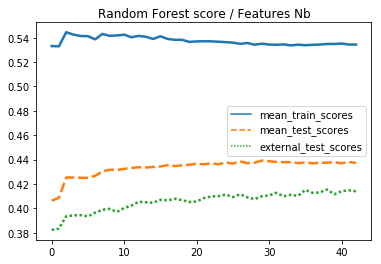

In [16]:

plot_scores(nb_feat_mean_train_scores, nb_feat_mean_test_scores, nb_feat_ext_test_scores, "Random Forest score / Features Nb")

We see here that the more we had features, among the one we have filtered with correlation stude the less we are overfitting.<br>
So the more data we have the best it is. <br>


In [17]:
# Max gini scores at iteration :
print("Maximum gini score (on the internal test CV) is reached for a feature number of : "+str( 6+nb_feat_mean_test_scores.index(max(nb_feat_mean_test_scores))))

Maximum gini score (on the internal test CV) is reached for a feature number of : 35


<b>Tune Nb Trees</b>

In [18]:
from sklearn.model_selection import GridSearchCV

optim_nb_features = 6+nb_feat_mean_test_scores.index(max(nb_feat_mean_test_scores))

# For various forest size fit and evaluate models performances
nb_trees_mean_train_scores = list()
nb_trees_mean_test_scores=list()
nb_trees_ext_test_scores = list()
x_values = range(100,600,50)
# For a sequence of forest size evaluate the random forest model built
for n_trees in x_values :
    
    rf = RandomForestClassifier(n_estimators=n_trees, 
                                criterion = "gini", 
                                min_impurity_decrease = 0, 
                                max_depth=6,
                                class_weight = {-1:1, 1:3}, 
                                max_features=6, 
                                oob_score = True,
                                n_jobs=-1,
                                random_state=41)
    
    # Save the current model metrics 
    std, mean_train, mean_test, ext_test_score, rf_trained, rf_feat_imp = double_split_train_test(rf, train_dummies[auto_selected_cols[:optim_nb_features]], target, outliers_idx, nb_CV = 5, print_scores=False)
    nb_trees_mean_train_scores.append(mean_train)
    nb_trees_mean_test_scores.append(mean_test)
    nb_trees_ext_test_scores.append(ext_test_score)

    


In [20]:
print( "The max test is obtained for "+str(100+(nb_trees_mean_test_scores.index(max(nb_trees_mean_test_scores)))*50)+" trees ")
print("The best test score is : "+str(max(nb_trees_mean_test_scores)))

The max test is obtained for 400 trees 
The best test score is : 0.42718003884433176


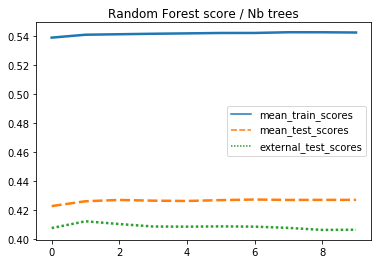

In [21]:
# Plot scores depending on the trees number in the forest
plot_scores(nb_trees_mean_train_scores, nb_trees_mean_test_scores, nb_trees_ext_test_scores, "Random Forest score / Nb trees")


<br>
<b>Tune the number of features at split</b>

In [22]:
# For various number of features to consider at split, fit and evaluate models performances
feat_split_mean_train_scores = list()
feat_split_mean_test_scores=list()
feat_split_ext_test_scores = list()

# For a sequence of feature to consider to split data 
x_values = range(3,optim_nb_features,1)
for n_features_per_split in x_values:
    
    rf = RandomForestClassifier(n_estimators=400, 
                                criterion = "gini", 
                                min_impurity_decrease = 0, 
                                max_depth=6,
                                class_weight = {-1:1, 1:3}, 
                                max_features=n_features_per_split, 
                                oob_score = True,
                                n_jobs=-1,
                                random_state=41)
    
    # Save the current model metrics 
    std, mean_train, mean_test, ext_test_score, rf_trained, rf_feat_imp = double_split_train_test(rf, train_dummies[auto_selected_cols[:optim_nb_features]], target, outliers_idx, nb_CV = 5, print_scores=False)
    feat_split_mean_train_scores.append(mean_train)
    feat_split_mean_test_scores.append(mean_test)
    feat_split_ext_test_scores.append(ext_test_score)
    

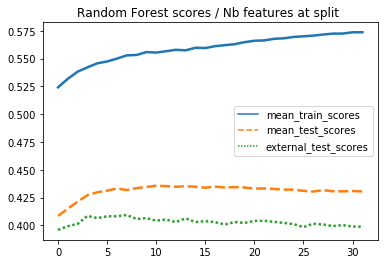

In [23]:
# Plot scores depending on the features number to consider at split 
plot_scores(feat_split_mean_train_scores, feat_split_mean_test_scores, feat_split_ext_test_scores, "Random Forest scores / Nb features at split ")


In [24]:
print( "The max test is obtained for "+str(3+(feat_split_mean_test_scores.index(max(feat_split_mean_test_scores))))+" features at split ")
print("The best test score is : "+str(max(feat_split_mean_test_scores)))

The max test is obtained for 13 features at split 
The best test score is : 0.4356404968267496


<br>
<b>Tune trees depth</b>

In [25]:
# For various trees depth fit and evaluate models performances
depth_mean_train_scores = list()
depth_mean_test_scores=list()
depth_ext_test_scores = list()

# For a sequence of feature to consider to split data 
x_values = range(3,15,1)
for c_max_depth in x_values:
    
    # Define and fit the model
    rf = RandomForestClassifier(n_estimators=400, 
                                criterion = "gini", 
                                min_impurity_decrease = 0, 
                                max_depth=c_max_depth,
                                class_weight = {-1:1, 1:3}, 
                                max_features=13, 
                                oob_score = True,
                                n_jobs=-1,
                                random_state=41)
    
    # Save the current model metrics 
    std, mean_train, mean_test, ext_test_score, rf_trained, rf_feat_imp = double_split_train_test(rf, train_dummies[auto_selected_cols[:optim_nb_features]], target, outliers_idx, nb_CV = 5, print_scores=False)
    depth_mean_train_scores.append(mean_train)
    depth_mean_test_scores.append(mean_test)
    depth_ext_test_scores.append(ext_test_score)

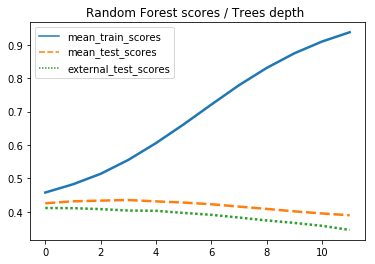

In [26]:
# Plot scores depending on the trees depth 
plot_scores(depth_mean_train_scores, depth_mean_test_scores, depth_ext_test_scores, "Random Forest scores / Trees depth ")


In [27]:
print( "The max test is obtained for "+str(3+(depth_mean_test_scores.index(max(depth_mean_test_scores))))+" trees depth ")
print("The best test score is : "+str(max(depth_mean_test_scores)))

The max test is obtained for 6 trees depth 
The best test score is : 0.4356404968267496


Increasing depth generate huge overfitting.<br>
The best mean test score is obtained for trees with depth of 6 levels.<br>

<b>Tune class weight</b>

In [28]:
# For various clas weight fit and evaluate models performances
weight_mean_train_scores = list()
weight_mean_test_scores=list()
weight_ext_test_scores = list()

# For a sequence of feature to consider to split data 
x_values = range(1, 10, 1)
for c_weight in x_values:
    
    # Define and fit the model
    rf = RandomForestClassifier(n_estimators=400, 
                                criterion = "gini", 
                                min_impurity_decrease = 0, 
                                max_depth=6,
                                class_weight = {-1:1, 1:c_weight}, 
                                max_features=13, 
                                oob_score = True,
                                n_jobs=-1,
                                random_state=41)
    
    # Save the current model metrics 
    std, mean_train, mean_test, ext_test_score, rf_trained, rf_feat_imp = double_split_train_test(rf, train_dummies[auto_selected_cols[:optim_nb_features]], target, outliers_idx, nb_CV = 5, print_scores=False)
    weight_mean_train_scores.append(mean_train)
    weight_mean_test_scores.append(mean_test)
    weight_ext_test_scores.append(ext_test_score)

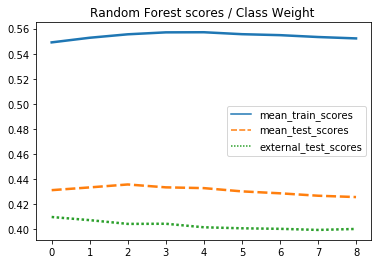

In [29]:
# Plot scores depending on the features number to consider at split 
plot_scores(weight_mean_train_scores, weight_mean_test_scores, weight_ext_test_scores, "Random Forest scores / Class Weight ")


In [30]:
print( "The max test is obtained for a weight ratio at "+str((weight_mean_test_scores.index(max(weight_mean_test_scores)))))
print("The best test score is : "+str(max(weight_mean_test_scores)))

The max test is obtained for a weight ratio at 2
The best test score is : 0.4356404968267496


<b>Train a random Forest with these parameters on a subset of features</b>

Save the RF model

In [34]:
# Retrain RF on best features      
rf = RandomForestClassifier(
                            max_depth=6, 
                            class_weight = {-1:1, 1:2}, 
                            criterion = 'gini',
                            max_features = 13,
                            min_impurity_decrease = 0,
                            n_estimators = 400,
                            oob_score = True,
                            n_jobs=-1,
                            random_state=41)


target_s = target.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
rf.fit(train_dummies[auto_selected_cols[:optim_nb_features]], target_s)

    

RandomForestClassifier(bootstrap=True, class_weight={-1: 1, 1: 2},
            criterion='gini', max_depth=6, max_features=13,
            max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=True, random_state=41,
            verbose=0, warm_start=False)

In [35]:
# Check features
std, mean_train, mean_test, ext_test_score, rf_trained, rf_feature_importances = double_split_train_test(rf, train_dummies[auto_selected_cols[:optim_nb_features]], target, outliers_idx, nb_CV = 5)

Train mean score: 0.5527335950174735
Test mean score : 0.4332947889581229
STD Test score: 0.013252216955685955
External Test score : 0.40716681262014043


In [ ]:
# Predict and save result
model_pred = rf.predict_proba(test_u[auto_selected_cols[:optim_nb_features]])[:,1]
model_pred_df = pd.DataFrame({"target":model_pred})
model_pred_df.to_csv("./lmartin_submission.csv")



## Train a XGBoost Classifier model

### Select features for XGBoost Classifier

In [36]:
import xgboost as xgb
from sklearn import metrics

target_s = target.apply(lambda row: -1 if row['target']==0 else 1, axis=1)

# Get feature importance for XGBoost
xgb_clf1 = xgb.XGBClassifier().fit(train_dummies, target_s)
xgb_feature_importances = pd.DataFrame(xgb_clf1.feature_importances_, index = train_dummies.columns, columns=['importance']).sort_values('importance', ascending=False)
ordered_cols_by_importance = list(xgb_feature_importances.index)

# Then go forward removing features correlated over corr_threshold
# Get correlation
corr = train_dummies[ordered_cols_by_importance].corr()

# Step forward filtering out features with more than a given threshold correlation 
corr_threshold = 0.5
columns_mask = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_threshold:
            if columns_mask[j]:
                columns_mask[j] = False

auto_selected_cols = train_dummies[ordered_cols_by_importance].columns[columns_mask]

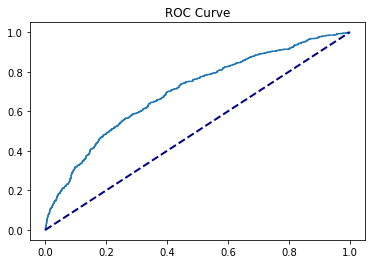

Confusion matrix, without normalization
[[2302   79]
 [ 587  101]]


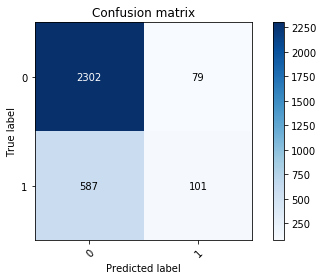

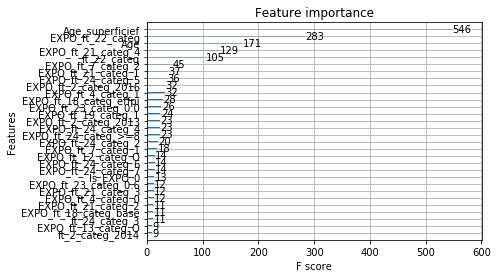

0.3989468466444625

In [37]:
# First XGBClassifier 
from xgboost import plot_importance

def first_xgb(train_complete_df, target):
    # First define External test dataset to permit model comparison
    X_train, X_test, y_train, y_test = train_test_split(train_complete_df, target, test_size=0.30, random_state=41)
    y_train_s = y_train.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    y_test_s = y_test.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    #target_s = target.apply(lambda row: -1 if row['target']==0 else 1, axis=1)

    xgb_clf1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=9999999999,
       n_estimators=600, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.4)

    xgb_clf1.fit(X_train, y_train_s)
    xgb_clf_pred_proba = xgb_clf1.predict_proba(X_test)[:, 1]
    
    # Display ROD Curve
    fpr, tpr, _ = metrics.roc_curve(y_test.target, xgb_clf_pred_proba)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC Curve")
    plt.show()
    
    # Display confusion matrix
    analyze_model(xgb_clf_pred_proba, y_test.target)
    
    plot_importance(xgb_clf1, max_num_features=30)
    plt.show()
    
    return xgb_clf1, gini_normalized(y_test.target, xgb_clf_pred_proba)

xgb_clf1, gini_score = first_xgb(train_dummies[auto_selected_cols], target)
gini_score

In [38]:
# For various features number took among the feature importance list produced with "auto_selected_cols", 
# fit and evaluate models performances
nb_feat_mean_train_scores = list()
nb_feat_mean_test_scores=list()
nb_feat_ext_test_scores = list()
x_values = range(3,len(auto_selected_cols))

for i in x_values:
    # Define the current set of features
    list_var = list(xgb_feature_importances[:i].index)    
      
    
    # Train and get scores
    std, mean_train, mean_test, ext_test_score, xgb_trained, xgb_feat_imp = double_split_train_test(xgb_clf1, train_dummies[list_var], target, outliers_idx, nb_CV = 5, print_scores=True)
    nb_feat_mean_train_scores.append(mean_train)
    nb_feat_mean_test_scores.append(mean_test)
    nb_feat_ext_test_scores.append(ext_test_score)

    
    
    

Train mean score: 0.44986824240303813
Test mean score : 0.4189840982711835
STD Test score: 0.020272080743607337
External Test score : 0.39640873118081327
Train mean score: 0.4496508625612411
Test mean score : 0.4171977653787196
STD Test score: 0.022038496428999976
External Test score : 0.3929980289503008
Train mean score: 0.4532062709360318
Test mean score : 0.4206083131136696
STD Test score: 0.02147908525033506
External Test score : 0.3978700733924558
Train mean score: 0.4657500632735192
Test mean score : 0.4318168965360799
STD Test score: 0.018468574372043578
External Test score : 0.40796119716190526
Train mean score: 0.46547626251855173
Test mean score : 0.4330478397143581
STD Test score: 0.019041945424179717
External Test score : 0.4072210368209435
Train mean score: 0.47180509436137374
Test mean score : 0.43889641920351685
STD Test score: 0.017142590878836052
External Test score : 0.407494869034999
Train mean score: 0.4721221994028165
Test mean score : 0.4399292539499656
STD Test s

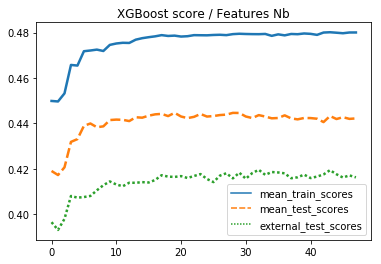

In [39]:
plot_scores(nb_feat_mean_train_scores, nb_feat_mean_test_scores, nb_feat_ext_test_scores, "XGBoost score / Features Nb")

After a number of features, internal and external test follow a sinusoid.<br>
We won't remove features but will use further the L1 and L2 xgb regulation to moderate some features influence and improve performance.

In [40]:
optim_feat_nb = train_dummies.shape[1]

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  6.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc',
       eval_set=[(       Age_superficief    Age  EXPO_ft_22_categ  EXPO_ft_21_categ_4  \
3396         27,000.00  36.00          1,974.59                1.00
8758         67,100.00  55.00          1,960.00                0.00
6804         87,677.00  43.00          1,970.00                0.00
4482 ...   -1
6607    -1
254     -1
1883    -1
6446    -1
22      -1
1016    -1
Length: 3069, dtype: int64)],
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=9999999999, n_estimators=600, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=2, seed=42,
       silent=True, subsample=0.5)


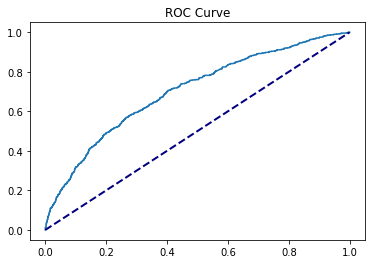

Confusion matrix, without normalization
[[2043  338]
 [ 417  271]]


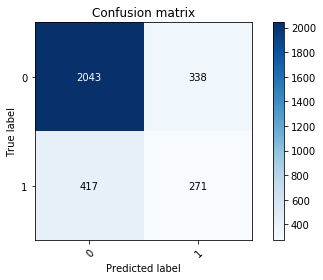

0.4015388296885225

In [41]:
# First hyperparameters exploration
def hyperparams_research(train_complete_df, target):
    
    X_train, X_test, y_train, y_test = train_test_split(train_complete_df, target, test_size=0.30, random_state=41)
    y_train_s = y_train.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    y_test_s = y_test.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    
     
    eval_set = [(X_test[auto_selected_cols[:optim_feat_nb]], y_test_s)]
    xgb_clf = xgb.XGBClassifier(booster='gbtree', n_jobs=-1, missing=9999999999, 
                             eval_metric="auc", eval_set=eval_set, seed=42)

    params={
    'max_depth': [2, 3, 4], #[4, 5, 6], 
    'subsample': [0.5], #[0.4, 0.5, 0.6],         # Boosting sample size
    'colsample_bytree': [ 0.8 ], # Sample columns ratio by tree
    'colsample_bylevel' : [0.5, 1],
    'n_estimators': [400, 600],#[600], #[200, 400, 600], 
    'scale_pos_weight' : [2], #[2, 3],
    'learning_rate' : [0.001, 0.01], #[0.001, 0.005, 0.01],
    'reg_alpha' : [0.05, 0.1], #[0.01, 0.05, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1], #[0.01, 0.05, 0.1, 0.5, 1],
    'min_child_weight' : [ 0.5, 1]
    }

    rs = GridSearchCV(xgb_clf,
                  params,
                  cv=3,
                  scoring="roc_auc",
                  n_jobs=-1, 
                  verbose=2,
                  return_train_score=True)
    rs.fit(X_train[auto_selected_cols[:optim_feat_nb]], y_train_s)
    best_est = rs.best_estimator_
    print(best_est)

    xgb_clf_pred_proba = rs.predict_proba(X_test[auto_selected_cols[:optim_feat_nb]])[:, 1]
    # Display ROD Curve
    fpr, tpr, _ = metrics.roc_curve(y_test.target, xgb_clf_pred_proba)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC Curve")
    plt.show()
    
    # Display confusion matrix
    analyze_model(xgb_clf_pred_proba, y_test.target)
    
    
    return gini_normalized(y_test.target, xgb_clf_pred_proba)



hyperparams_research(train_dummies, target)



In [43]:
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc',
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=9999999999, n_estimators=600, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=2, seed=42,
       silent=True, subsample=0.5)


# Evaluate the model perf
std, mean_train, mean_test, ext_test_score, xg_trained, xg_feat_imp = double_split_train_test(xgb_clf, train_dummies[auto_selected_cols[:optim_feat_nb]], target, outliers_idx, nb_CV = 5, print_scores=True)        


Train mean score: 0.48002808658750523
Test mean score : 0.4347234812465487
STD Test score: 0.014859117876460881
External Test score : 0.4137821651181138


In [44]:
print(str(std) + " "+ str(mean_train)+ " "+ str(mean_test)+ " "+ str(ext_test_score))

0.014859117876460881 0.48002808658750523 0.4347234812465487 0.4137821651181138


# Prepare submission file

In [45]:
train_dummies_bckp = train_dummies.copy()
target_bckp = target.copy()

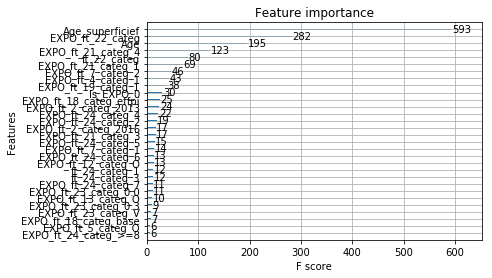

In [46]:
from xgboost import plot_importance
# Remove outliers
train_dummies.drop(outliers_idx)

target.target = target.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
target.drop(outliers_idx)

# Train
xgb_clf.fit(train_dummies[auto_selected_cols[:optim_feat_nb]], target.target)

# plot feature importance
plot_importance(xgb_clf, max_num_features=30)
plt.show()


In [47]:
# Predict and save result
model_pred = xgb_clf.predict_proba(test_dummies[auto_selected_cols[:optim_feat_nb]])[:,1]
model_pred_df = pd.DataFrame({"order":test_dummies["index"],"target":model_pred})
model_pred_df.to_csv("./test_without_Insee_submission.csv")

In [48]:
df = pd.read_csv("./test_without_Insee_submission.csv")
df.head()

,Unnamed: 0,order,target
0,0,130.00,0.28
1,1,274.00,0.37
2,2,399.00,0.25
3,3,652.00,0.32
4,4,794.00,0.46
